# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

Corrections for review:
    -Label smoothing
    -Dropout in discriminator
    -One more layer in generator
    -Xavier weight initializer

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

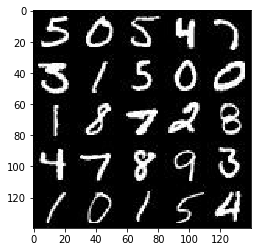

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

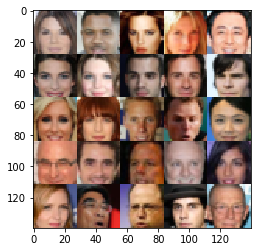

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    z_inputs = tf.placeholder(tf.float32, shape=(None, z_dim),  name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')

    return real_input_images, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    dropout_rate=0.8
    
    train = not reuse
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2,padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))
        x1 = tf.maximum(alpha*x1, x1)
        #x1 = tf.layers.dropout(x1, rate=dropout_rate, training=True)

        x2 = tf.layers.conv2d(x1, filters=128, kernel_size=5, strides=2,padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        #x2 = tf.layers.dropout(x2, rate=dropout_rate, training=True)
        
        x3 = tf.layers.conv2d(x2, filters=256, kernel_size=5, strides=2,padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        #x3 = tf.layers.dropout(x3, rate=dropout_rate, training=True)
        
        x4 = tf.reshape(x3, (-1, 4*4* 256 ))       
        logits = tf.layers.dense(x4, 1)
        output = tf.sigmoid(logits)
        
        
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)        
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=5, strides=1, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)        

        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='SAME', kernel_initializer=tf.contrib.layers.xavier_initializer(), kernel_regularizer=tf.contrib.layers.l2_regularizer(0.001))        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth=0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    if data_image_mode == "RGB":
        out_channel_dim = 3
    elif data_image_mode == "L":
        out_channel_dim = 1
        
    n_images=16
    steps=0
    print_every = 10
    show_every = 100
    
    input_real, input_z, learning_rate_tensor = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print(input_real.shape)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tensor:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tensor:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tensor:learning_rate})

                
                if steps % show_every == 0:                
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                    
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(?, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 3.8420... Generator Loss: 0.0400
Epoch 1/2... Discriminator Loss: 3.2718... Generator Loss: 0.0695
Epoch 1/2... Discriminator Loss: 2.7887... Generator Loss: 0.1533
Epoch 1/2... Discriminator Loss: 2.3587... Generator Loss: 0.1686
Epoch 1/2... Discriminator Loss: 2.0402... Generator Loss: 0.2511
Epoch 1/2... Discriminator Loss: 2.2362... Generator Loss: 0.1806
Epoch 1/2... Discriminator Loss: 1.9092... Generator Loss: 0.2922
Epoch 1/2... Discriminator Loss: 1.7819... Generator Loss: 0.3392
Epoch 1/2... Discriminator Loss: 1.8921... Generator Loss: 0.2779


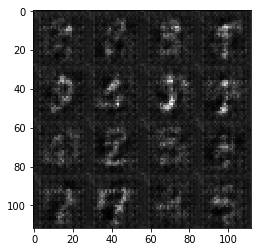

Epoch 1/2... Discriminator Loss: 1.7233... Generator Loss: 0.3536
Epoch 1/2... Discriminator Loss: 1.6006... Generator Loss: 0.4274
Epoch 1/2... Discriminator Loss: 1.7960... Generator Loss: 0.3227
Epoch 1/2... Discriminator Loss: 1.5896... Generator Loss: 0.3983
Epoch 1/2... Discriminator Loss: 1.6730... Generator Loss: 0.3494
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.4484
Epoch 1/2... Discriminator Loss: 1.5408... Generator Loss: 0.4662
Epoch 1/2... Discriminator Loss: 1.5296... Generator Loss: 1.1383
Epoch 1/2... Discriminator Loss: 1.5913... Generator Loss: 0.9505
Epoch 1/2... Discriminator Loss: 1.5019... Generator Loss: 0.9412


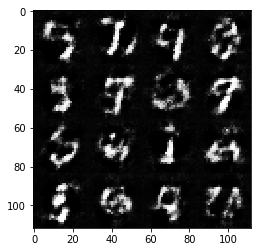

Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 1.4543... Generator Loss: 0.9174
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 1.1664
Epoch 1/2... Discriminator Loss: 1.5064... Generator Loss: 0.8837
Epoch 1/2... Discriminator Loss: 1.6144... Generator Loss: 1.2495
Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 1.0717
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 0.6819
Epoch 1/2... Discriminator Loss: 1.6683... Generator Loss: 1.0651
Epoch 1/2... Discriminator Loss: 1.5284... Generator Loss: 0.4717


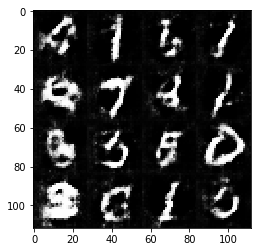

Epoch 1/2... Discriminator Loss: 1.6491... Generator Loss: 0.3732
Epoch 1/2... Discriminator Loss: 1.5145... Generator Loss: 0.4978
Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.4905
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.6449
Epoch 1/2... Discriminator Loss: 1.4920... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.5626... Generator Loss: 1.1946
Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 1.4736... Generator Loss: 0.5365
Epoch 1/2... Discriminator Loss: 1.6566... Generator Loss: 0.3908
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.5743


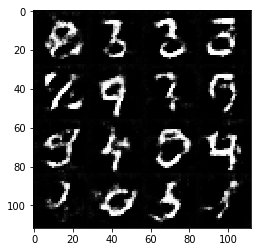

Epoch 1/2... Discriminator Loss: 2.0069... Generator Loss: 0.2261
Epoch 1/2... Discriminator Loss: 1.4311... Generator Loss: 0.6936
Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.6175
Epoch 1/2... Discriminator Loss: 1.5946... Generator Loss: 0.4110
Epoch 1/2... Discriminator Loss: 1.6135... Generator Loss: 0.4102
Epoch 1/2... Discriminator Loss: 1.5453... Generator Loss: 1.1733
Epoch 1/2... Discriminator Loss: 1.4569... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.4817... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.4500... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.4704... Generator Loss: 0.7083


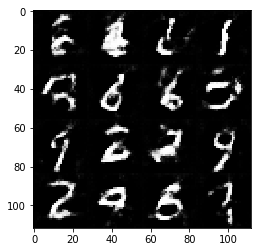

Epoch 1/2... Discriminator Loss: 1.6180... Generator Loss: 1.0040
Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 0.6554
Epoch 1/2... Discriminator Loss: 1.6719... Generator Loss: 0.3529
Epoch 1/2... Discriminator Loss: 1.4982... Generator Loss: 0.5760
Epoch 1/2... Discriminator Loss: 1.5080... Generator Loss: 0.7782
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 0.8898
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.4602... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.5136... Generator Loss: 0.6609


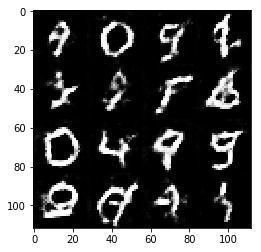

Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 0.8635
Epoch 1/2... Discriminator Loss: 1.8082... Generator Loss: 0.2817
Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.4343... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 1.5098... Generator Loss: 0.8097
Epoch 1/2... Discriminator Loss: 1.8442... Generator Loss: 1.1012
Epoch 1/2... Discriminator Loss: 1.4694... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 1.5212... Generator Loss: 0.4942


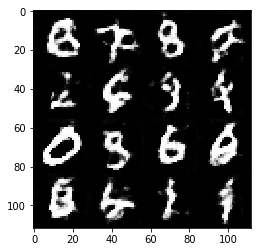

Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.5760
Epoch 1/2... Discriminator Loss: 1.4571... Generator Loss: 0.9360
Epoch 1/2... Discriminator Loss: 1.6006... Generator Loss: 1.1892
Epoch 1/2... Discriminator Loss: 1.4805... Generator Loss: 0.4768
Epoch 1/2... Discriminator Loss: 1.6592... Generator Loss: 0.3621
Epoch 1/2... Discriminator Loss: 1.5696... Generator Loss: 0.4085
Epoch 1/2... Discriminator Loss: 1.4850... Generator Loss: 0.5729
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.6308
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.4664
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.7919


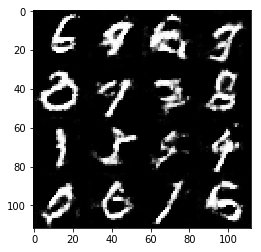

Epoch 1/2... Discriminator Loss: 1.5629... Generator Loss: 0.4918
Epoch 1/2... Discriminator Loss: 1.3096... Generator Loss: 0.8287
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 0.6245
Epoch 1/2... Discriminator Loss: 1.6568... Generator Loss: 0.3716
Epoch 1/2... Discriminator Loss: 1.6592... Generator Loss: 0.3638
Epoch 1/2... Discriminator Loss: 1.8665... Generator Loss: 0.2666
Epoch 1/2... Discriminator Loss: 1.5533... Generator Loss: 0.5188
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.6601
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.8232... Generator Loss: 0.3074


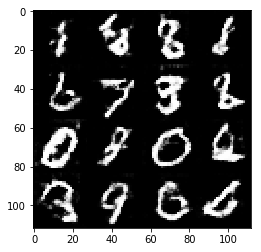

Epoch 1/2... Discriminator Loss: 1.4305... Generator Loss: 0.6097
Epoch 1/2... Discriminator Loss: 1.4857... Generator Loss: 0.4447
Epoch 1/2... Discriminator Loss: 1.5996... Generator Loss: 0.3914
Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 0.4325
Epoch 2/2... Discriminator Loss: 1.4957... Generator Loss: 0.4711
Epoch 2/2... Discriminator Loss: 1.4711... Generator Loss: 0.5035
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.5962
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.6461
Epoch 2/2... Discriminator Loss: 2.5487... Generator Loss: 0.1277
Epoch 2/2... Discriminator Loss: 1.3754... Generator Loss: 0.5706


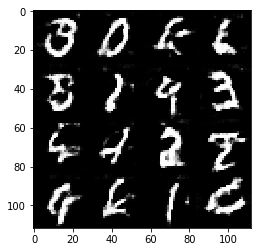

Epoch 2/2... Discriminator Loss: 1.4586... Generator Loss: 0.7461
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.5473
Epoch 2/2... Discriminator Loss: 1.4766... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 2.3195... Generator Loss: 2.0670
Epoch 2/2... Discriminator Loss: 1.7508... Generator Loss: 0.3080
Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 1.2911... Generator Loss: 0.6971


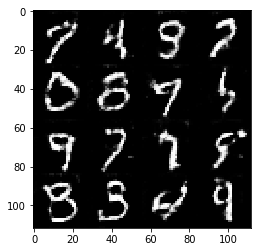

Epoch 2/2... Discriminator Loss: 1.7960... Generator Loss: 1.4648
Epoch 2/2... Discriminator Loss: 1.4772... Generator Loss: 0.4739
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.5698
Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.4239... Generator Loss: 0.5694
Epoch 2/2... Discriminator Loss: 1.6698... Generator Loss: 0.3448
Epoch 2/2... Discriminator Loss: 1.7775... Generator Loss: 0.2980
Epoch 2/2... Discriminator Loss: 1.5646... Generator Loss: 0.3987
Epoch 2/2... Discriminator Loss: 1.4823... Generator Loss: 0.4847
Epoch 2/2... Discriminator Loss: 1.4872... Generator Loss: 0.9090


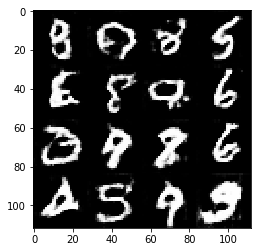

Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 1.2191... Generator Loss: 0.7843
Epoch 2/2... Discriminator Loss: 1.7704... Generator Loss: 1.3746
Epoch 2/2... Discriminator Loss: 1.5408... Generator Loss: 0.4881
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.8498
Epoch 2/2... Discriminator Loss: 1.3833... Generator Loss: 0.8237
Epoch 2/2... Discriminator Loss: 1.5388... Generator Loss: 0.4618
Epoch 2/2... Discriminator Loss: 1.4525... Generator Loss: 0.4936
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.9178


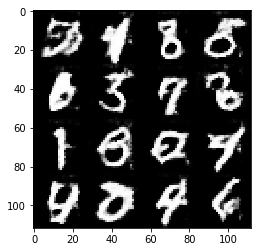

Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 0.9011
Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 0.5198
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.6903
Epoch 2/2... Discriminator Loss: 1.3875... Generator Loss: 0.6325
Epoch 2/2... Discriminator Loss: 1.5510... Generator Loss: 0.3890
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 1.2999
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 0.8333
Epoch 2/2... Discriminator Loss: 1.3595... Generator Loss: 0.5441
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 1.4351


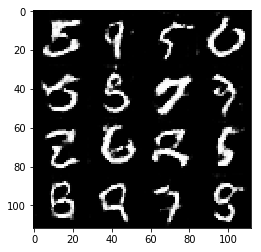

Epoch 2/2... Discriminator Loss: 1.4678... Generator Loss: 0.4448
Epoch 2/2... Discriminator Loss: 1.7064... Generator Loss: 0.3363
Epoch 2/2... Discriminator Loss: 1.4725... Generator Loss: 0.4474
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.6119
Epoch 2/2... Discriminator Loss: 1.7508... Generator Loss: 0.3188
Epoch 2/2... Discriminator Loss: 1.7627... Generator Loss: 0.3309
Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 0.7892
Epoch 2/2... Discriminator Loss: 1.4328... Generator Loss: 0.5772
Epoch 2/2... Discriminator Loss: 3.9859... Generator Loss: 3.1516
Epoch 2/2... Discriminator Loss: 1.8392... Generator Loss: 0.2837


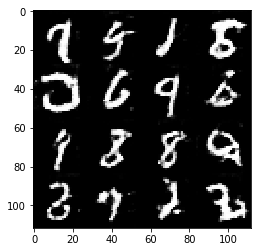

Epoch 2/2... Discriminator Loss: 1.4822... Generator Loss: 0.6339
Epoch 2/2... Discriminator Loss: 1.1956... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.6892... Generator Loss: 0.3339
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.9544
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.2758... Generator Loss: 0.6566
Epoch 2/2... Discriminator Loss: 1.5219... Generator Loss: 1.2054
Epoch 2/2... Discriminator Loss: 1.6192... Generator Loss: 0.3971
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 0.5686
Epoch 2/2... Discriminator Loss: 1.4101... Generator Loss: 0.9577


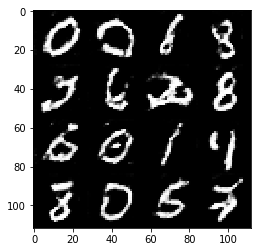

Epoch 2/2... Discriminator Loss: 1.5051... Generator Loss: 0.4324
Epoch 2/2... Discriminator Loss: 1.5433... Generator Loss: 0.4752
Epoch 2/2... Discriminator Loss: 1.0560... Generator Loss: 1.0679
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 0.6807
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.5374
Epoch 2/2... Discriminator Loss: 2.0379... Generator Loss: 0.2587
Epoch 2/2... Discriminator Loss: 1.4972... Generator Loss: 0.5760
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.8970
Epoch 2/2... Discriminator Loss: 1.3970... Generator Loss: 0.5350


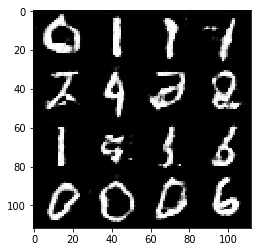

Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 1.0264
Epoch 2/2... Discriminator Loss: 1.3316... Generator Loss: 1.2766
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 2.1059... Generator Loss: 0.2288
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.6642
Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 1.2257
Epoch 2/2... Discriminator Loss: 1.0966... Generator Loss: 1.0806
Epoch 2/2... Discriminator Loss: 1.2723... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 1.4717... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.7041


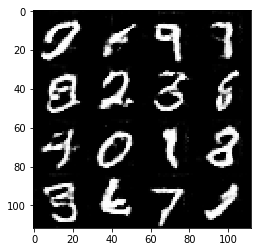

Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 0.8585
Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 1.0190
Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.4784
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 0.5715
Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 1.7895... Generator Loss: 1.2759
Epoch 2/2... Discriminator Loss: 1.1377... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 0.5204


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 4.8678... Generator Loss: 0.0204
Epoch 1/1... Discriminator Loss: 4.8496... Generator Loss: 0.0572
Epoch 1/1... Discriminator Loss: 3.9455... Generator Loss: 0.0767
Epoch 1/1... Discriminator Loss: 2.9970... Generator Loss: 0.1228
Epoch 1/1... Discriminator Loss: 3.2660... Generator Loss: 0.0909
Epoch 1/1... Discriminator Loss: 2.4680... Generator Loss: 0.3653
Epoch 1/1... Discriminator Loss: 2.5921... Generator Loss: 0.2109
Epoch 1/1... Discriminator Loss: 3.1483... Generator Loss: 0.0847
Epoch 1/1... Discriminator Loss: 2.8390... Generator Loss: 0.1832


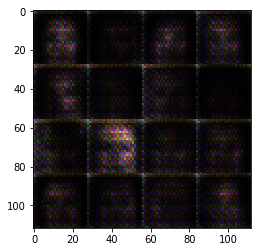

Epoch 1/1... Discriminator Loss: 2.3666... Generator Loss: 0.2316
Epoch 1/1... Discriminator Loss: 2.5974... Generator Loss: 0.2734
Epoch 1/1... Discriminator Loss: 2.6404... Generator Loss: 0.1752
Epoch 1/1... Discriminator Loss: 2.5734... Generator Loss: 0.1861
Epoch 1/1... Discriminator Loss: 2.2360... Generator Loss: 0.2497
Epoch 1/1... Discriminator Loss: 2.2596... Generator Loss: 0.2127
Epoch 1/1... Discriminator Loss: 2.2246... Generator Loss: 0.2527
Epoch 1/1... Discriminator Loss: 1.9548... Generator Loss: 0.3064
Epoch 1/1... Discriminator Loss: 2.3424... Generator Loss: 0.2856
Epoch 1/1... Discriminator Loss: 2.1943... Generator Loss: 0.2225


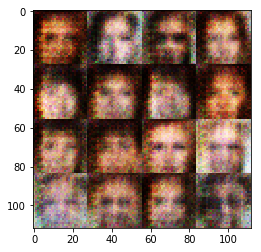

Epoch 1/1... Discriminator Loss: 2.1220... Generator Loss: 0.4077
Epoch 1/1... Discriminator Loss: 2.2153... Generator Loss: 0.2211
Epoch 1/1... Discriminator Loss: 1.9919... Generator Loss: 0.2819
Epoch 1/1... Discriminator Loss: 1.8122... Generator Loss: 0.3932
Epoch 1/1... Discriminator Loss: 2.2284... Generator Loss: 0.2648
Epoch 1/1... Discriminator Loss: 1.8003... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 1.9464... Generator Loss: 0.4515
Epoch 1/1... Discriminator Loss: 2.1669... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 1.8044... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 1.9348... Generator Loss: 0.3667


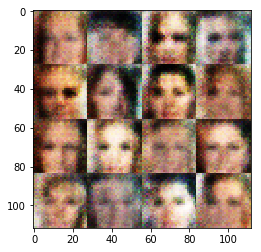

Epoch 1/1... Discriminator Loss: 1.8371... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 1.9129... Generator Loss: 0.3293
Epoch 1/1... Discriminator Loss: 1.8124... Generator Loss: 0.4082
Epoch 1/1... Discriminator Loss: 1.9512... Generator Loss: 0.3037
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.8051... Generator Loss: 0.4954
Epoch 1/1... Discriminator Loss: 1.6682... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.7945... Generator Loss: 0.6383


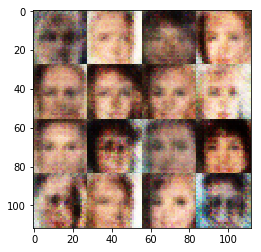

Epoch 1/1... Discriminator Loss: 1.7290... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 1.6079... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.6490... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.7008... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 1.7519... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.6302... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.5878... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.6059


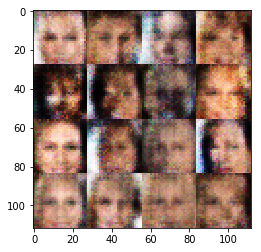

Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.7754... Generator Loss: 0.4028
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.7157... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.6060... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.6260... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.5592
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.6869


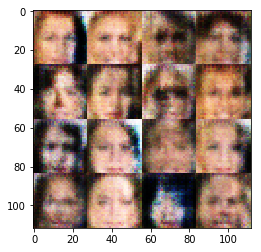

Epoch 1/1... Discriminator Loss: 1.6010... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.8034... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.6398... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.5676... Generator Loss: 0.5793
Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.5396


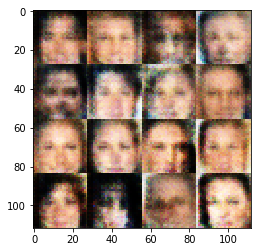

Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.6134... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.5986


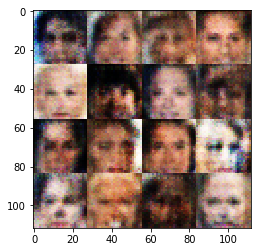

Epoch 1/1... Discriminator Loss: 1.6228... Generator Loss: 0.4973
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.5783... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.6056... Generator Loss: 0.5267


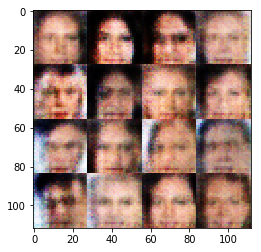

Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.5822... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.6783


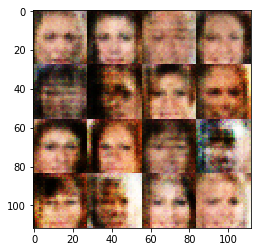

Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6853


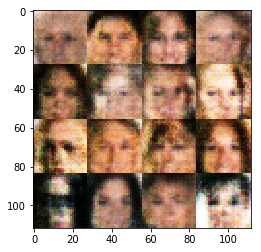

Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6411


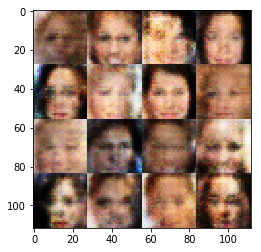

Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.7353


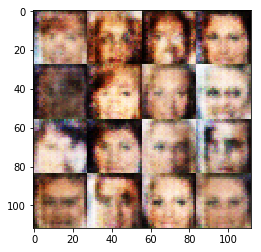

Epoch 1/1... Discriminator Loss: 1.5503... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.6191


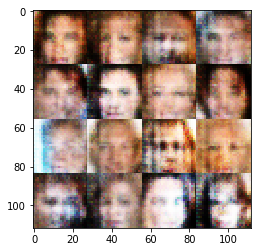

Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.5051... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.6401


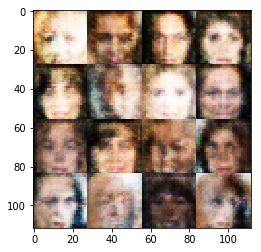

Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.5731... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4846... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6945


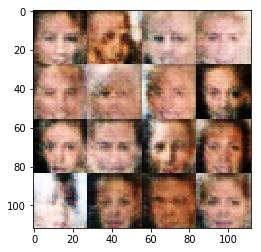

Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.4777... Generator Loss: 0.6721


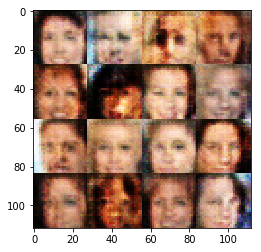

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.6489


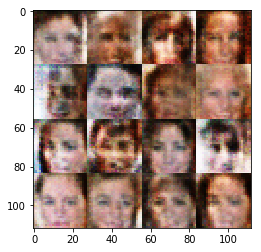

Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7490


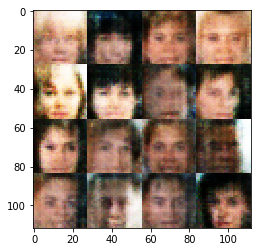

Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.8244


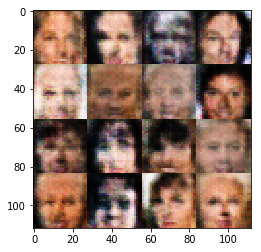

Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6986


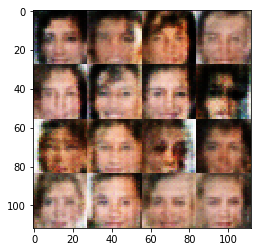

Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7259


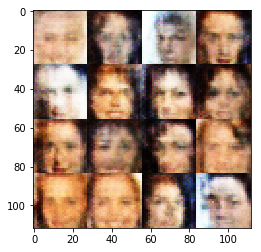

Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6837


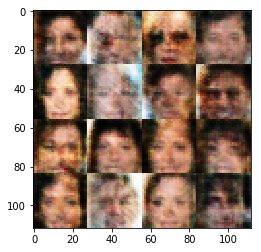

Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7449


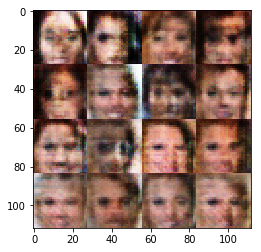

Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7732


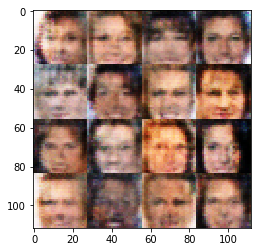

Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6002


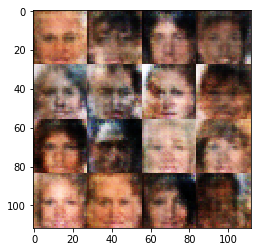

Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.6888


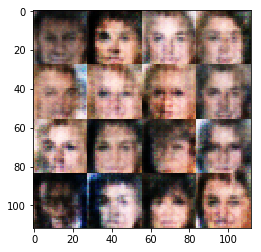

Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6427
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.5982


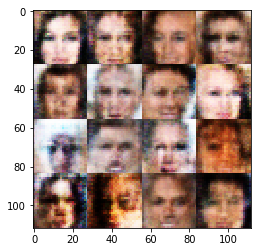

Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.5001... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7660


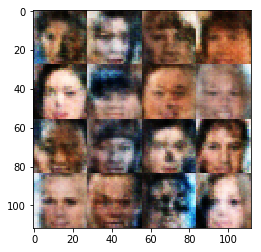

Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7260


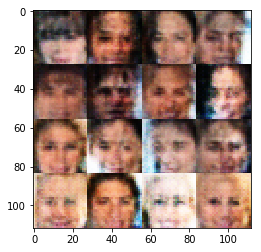

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7100


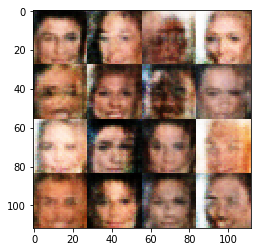

Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7974


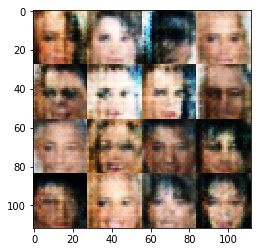

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.8716


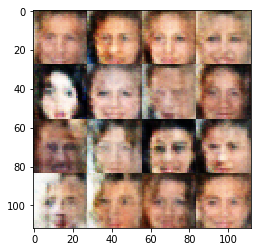

Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6568


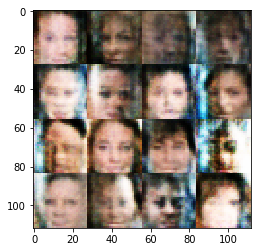

Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.6366
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.6602


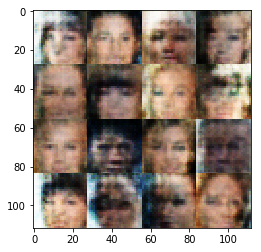

Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.6453


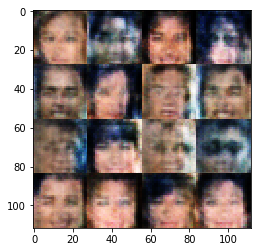

Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7404


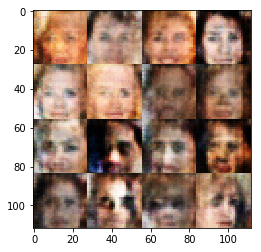

Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7704


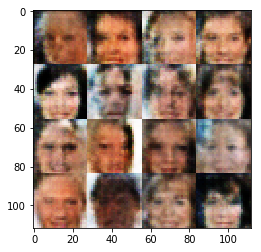

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7923


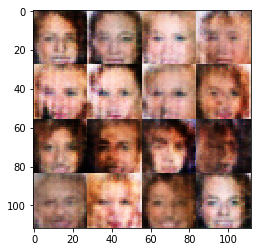

Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7728


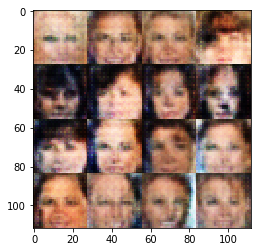

Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7301


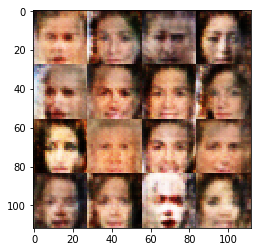

Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.8034


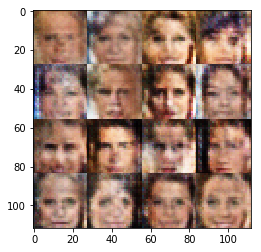

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7216


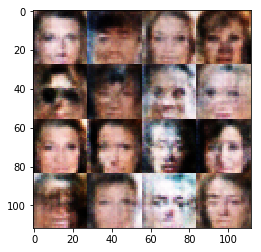

Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7519


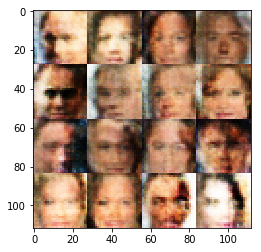

Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4515... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6945


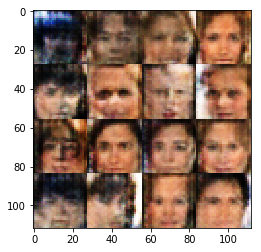

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7200


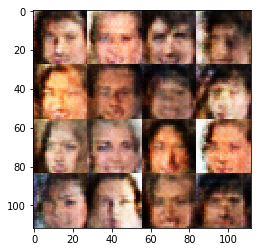

Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7414


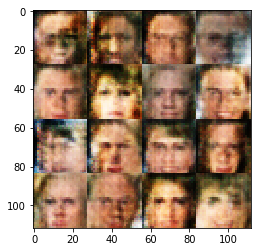

Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7098


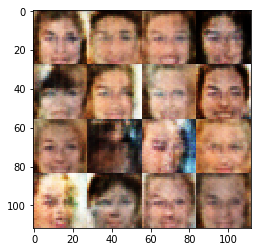

Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7839


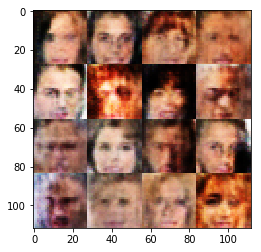

Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6622


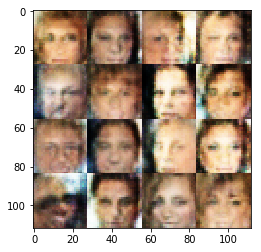

Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7776


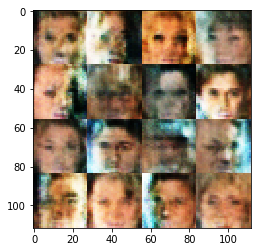

Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7949


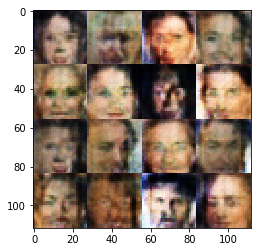

Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.8179


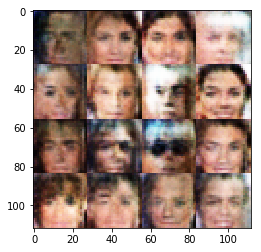

Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6884


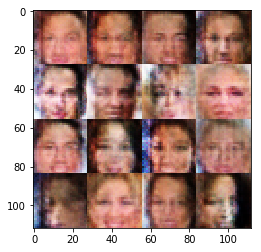

Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7776


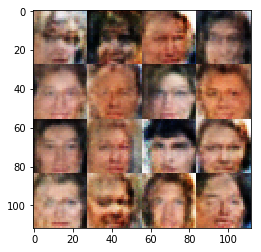

Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7498


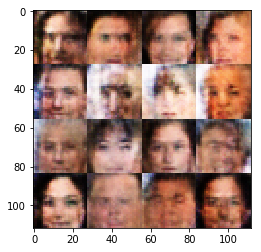

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7637


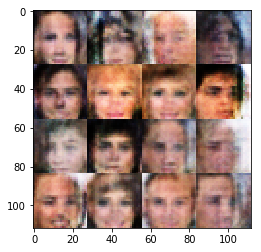

Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7730


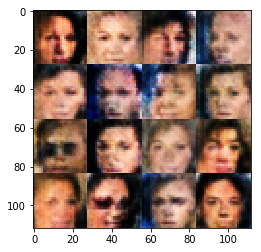

Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6957


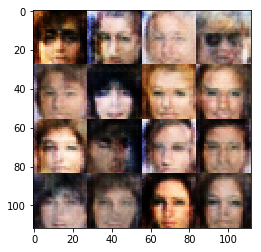

Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7167


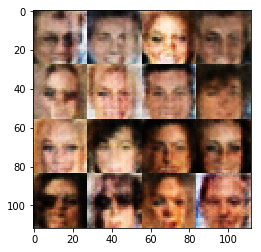

Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7560


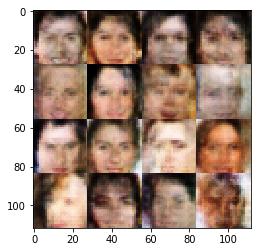

Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8064


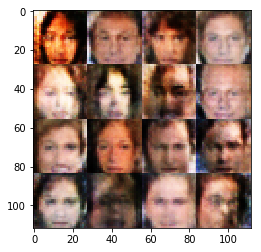

Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7643


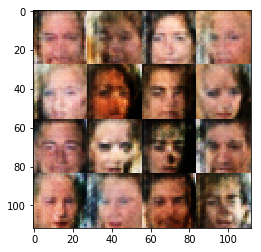

Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.8224


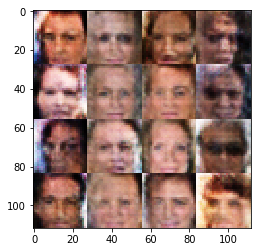

Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.6206


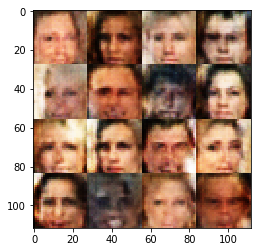

Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7490


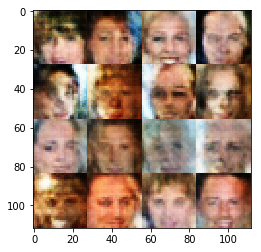

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5893


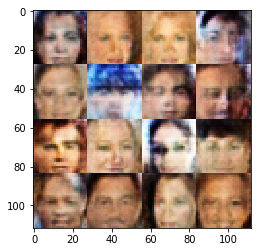

Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8412


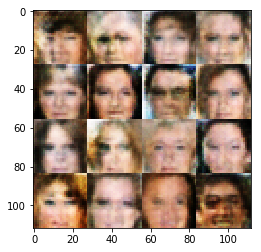

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8016


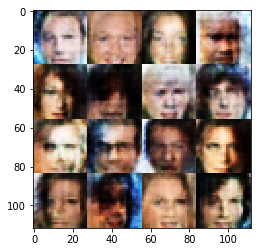

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6066


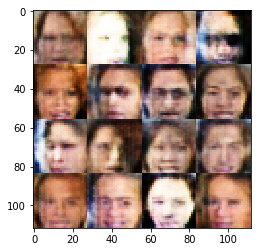

Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7840


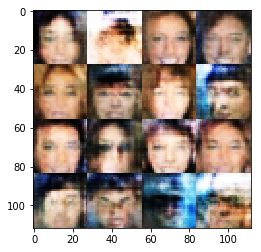

Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8003


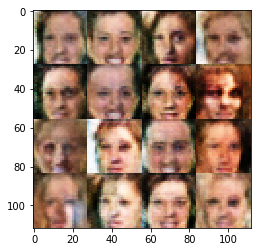

Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7942


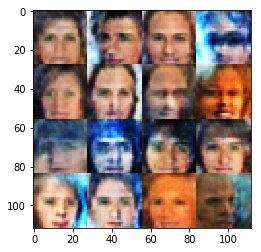

Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.8682


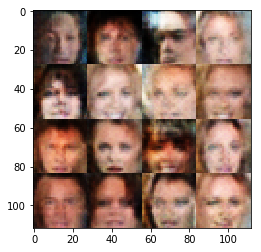

Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7983


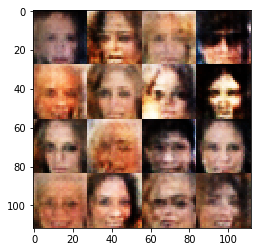

Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7365


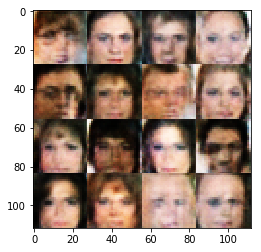

Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6472


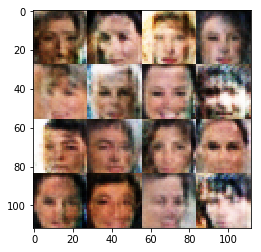

Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7036


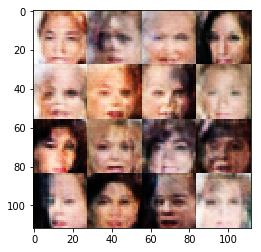

Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7208


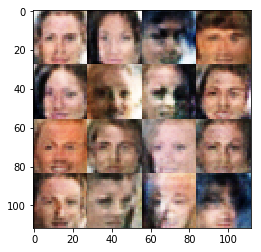

Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7153


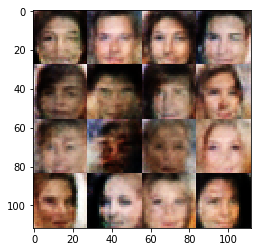

Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6956


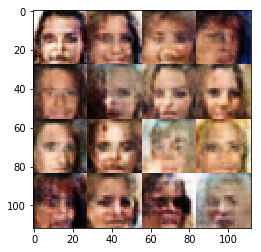

Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7366


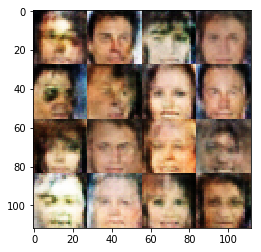

Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7554


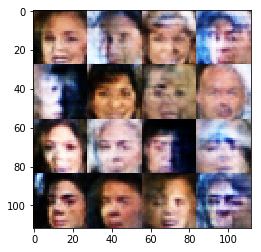

Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7743


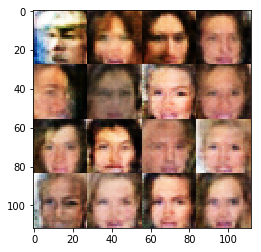

Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7046


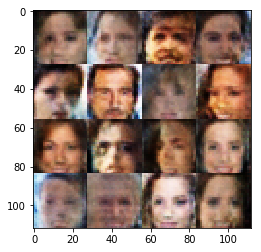

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.6960


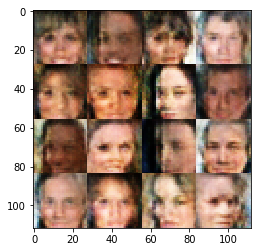

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7800


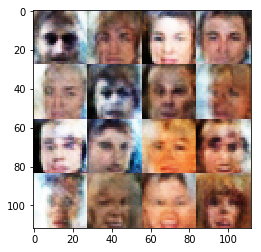

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7740


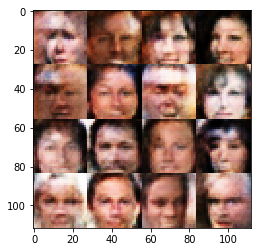

Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7484


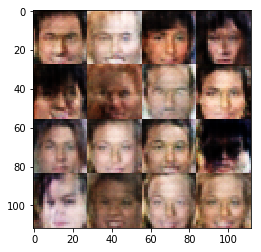

Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7173


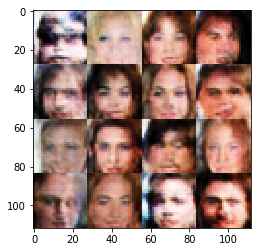

Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7597


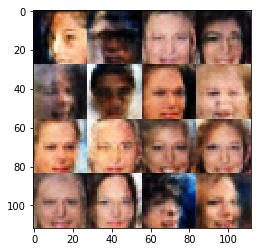

Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8180


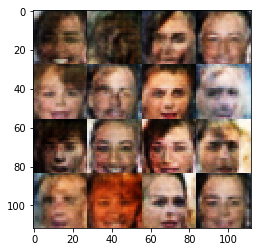

Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7069


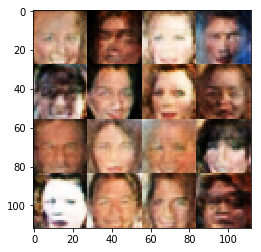

Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.6481


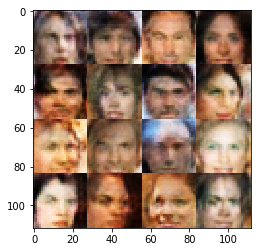

Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7728


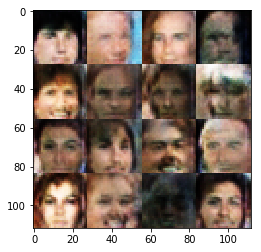

Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7811


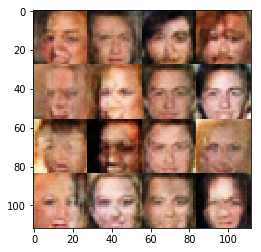

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7277


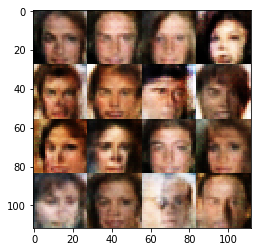

Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7266


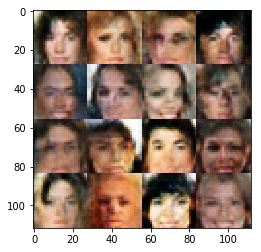

Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8682


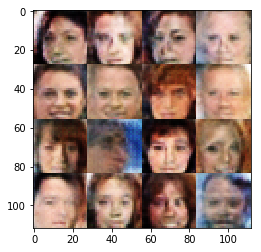

Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8328


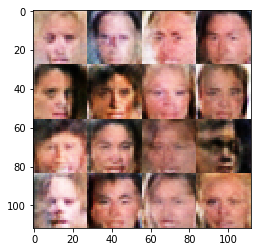

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7397


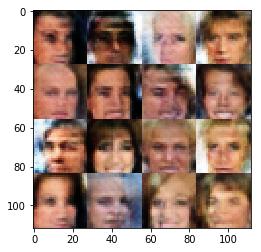

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7746


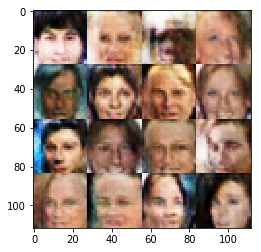

Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7711


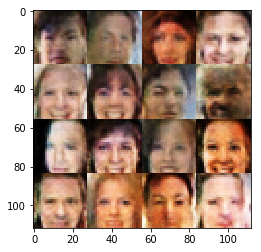

Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7990


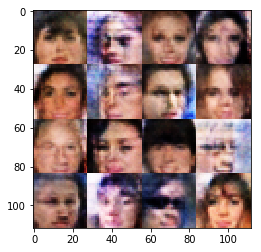

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7950


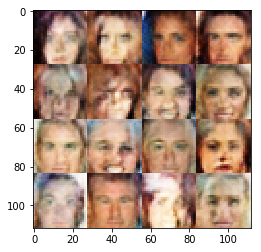

Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7997


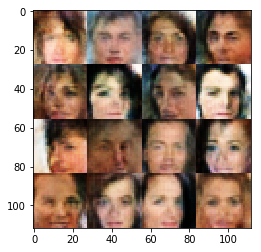

Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7414


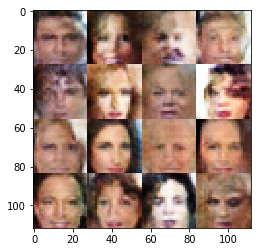

Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7538


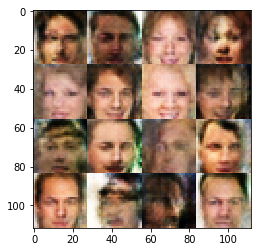

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7800


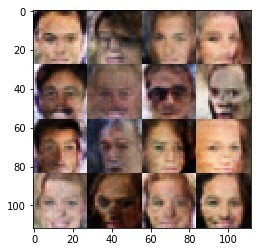

Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7170


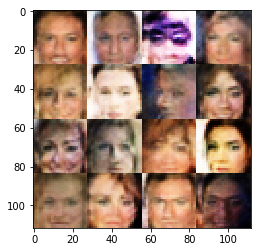

Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6958


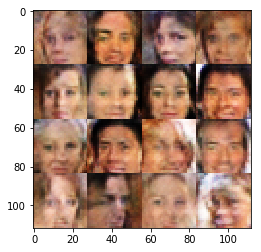

Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7713


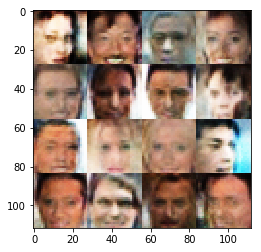

Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8301


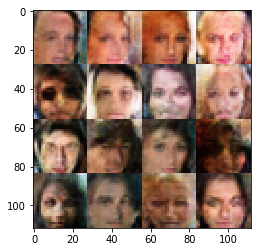

Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6774


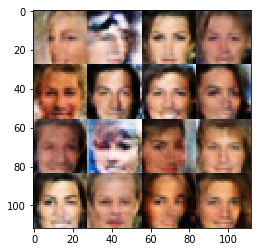

Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7508


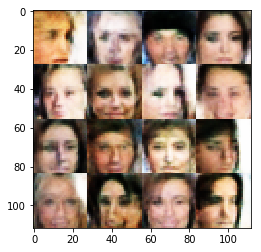

Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.8785


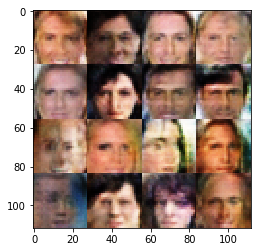

Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.8070


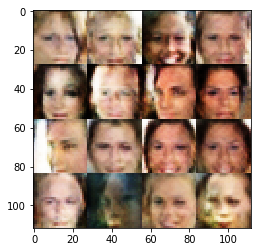

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7418


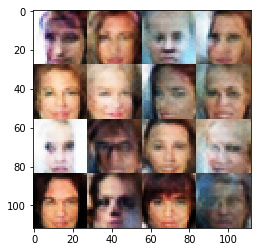

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7314


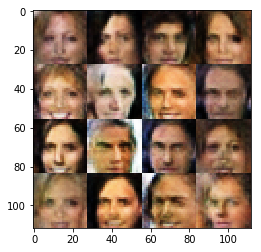

Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8239


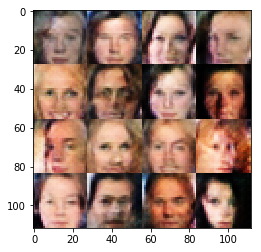

Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.8489


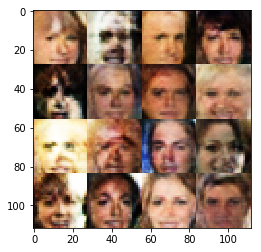

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7423


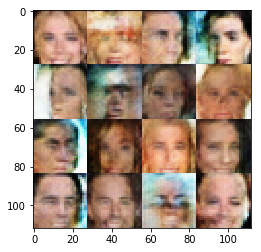

Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8002


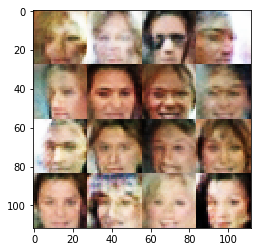

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.8469


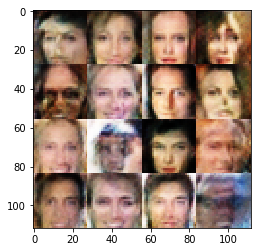

Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7617


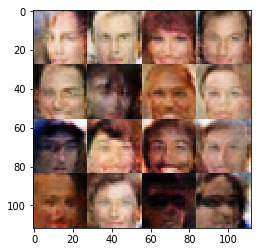

Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7461


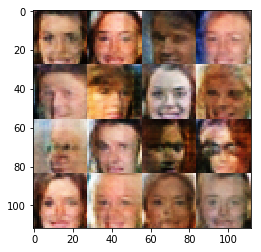

Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7817


In [20]:
batch_size = 16
z_dim = 128
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.